# Import

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from models.Transformers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stock_symbol = '2454.TW'
end_date = '2024-12-31'

num_class = 1
num_epochs = 500
fp16_training = True
short = False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
end_date = '2024-12-31'

model = TransformerDecoderOnly(num_class=num_class).to(device)
Model = model.model_type

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
"{:.2e}".format(total_params)

'1.32e+05'

# Model and result

3.313370199764476


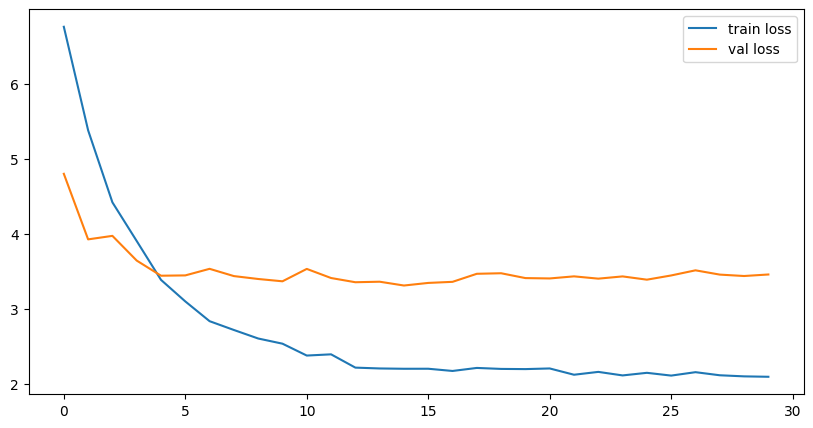

In [3]:
with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
print(infos['min val loss'])

with open(f'Temp/{Model}_class{num_class}_{stock_symbol}_TrainValHistLoss.pk', 'rb') as f:
    results = pickle.load(f)
train_loss = results['train']
val_loss = results['valid']

plt.figure(figsize=(10, 5))
plt.plot(train_loss[:], label='train loss')
plt.plot(val_loss[:], label='val loss')
plt.legend()
plt.show()


### Data

In [4]:
if num_class == 2:
    with open('../DataLoader/dataloader.pk', 'rb') as f:
        data = pickle.load(f)
    validloader = data['validloader']
    testloader = data['testloader']
elif num_class == 1:
    with open('../DataLoader/dataloader_1.pk', 'rb') as f:
        data = pickle.load(f)
    validloader = data['validloader']
    testloader = data['testloader']
with open('../DataLoader/dates.pk', 'rb') as f:
    dates = pickle.load(f)
with open('../DataLoader/data_clean.pk', 'rb') as f:
    df = pickle.load(f)
with open('../DataLoader/src.pk', 'rb') as f:
    src = pickle.load(f)
    
date_test = dates['test']
src = src.permute(2, 0, 1).to(device)
    
# ====================
# Valid 
x_valid = []
for x, y in validloader:
    x_valid.append(x)
x_valid = torch.cat(x_valid, dim = 0)

# ====================
# Check
for x, y in testloader:
    print(x.shape)
    break

torch.Size([32, 6, 100])


# Backtest 

### Function

In [5]:
def backtest_plot(i):
    global short, num_class
    
    # Prediction
    model.load_state_dict(torch.load(f'Model_Result/{Model}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval()    
    y_pred, acc = test_encoder(model, testloader)
    y_train_pred, acc = test_encoder(model, validloader)
    y_pred_numpy = y_pred.cpu().numpy()
    prediction = pd.DataFrame(y_pred_numpy)
        
    # Scaling with predicted valid set
    y_train_numpy = y_train_pred.detach().cpu().numpy()
    scaler = StandardScaler()
    scaler.fit(y_train_numpy)
    prediction = pd.DataFrame(scaler.transform(prediction))
    
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    # In Encoder Decoder need to ignore the last batch if last batch's batch size != batch_size
    # so use date_test[:len(prediction)]
    prediction['Date'] = date_test[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')
    
    # Close is normalised while use Close in training, set Close to original
    true_and_pred['Close'] = true_and_pred['Close_origin']
    
    # Get the predicted doc_1. If class == 1 the the y_pred is the doc_1
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. d~ is all percentile change
    """
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']/100))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']/100))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
    elif num_class == 1:
        true_and_pred['pred_doc_1'] /= 100
    true_and_pred['doc_1'] /= 100
    
    # Backtest
    """
    NOTE:
    For encoder-only and encoder-decoder since the second one need to drop last, 
    buy hold would not be the same
    """
    asset_list = []
    if num_class == 2:
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > 0.004:
                asset *= (1 + true)   
            if short and pred < -0.004:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        # print(f'Buy Hold last asset: {asset_buyhold}')
    else:
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (c, pred, true) in df_backtest.iterrows():
            # print(pred, true)
            if pred > 0.004:
                asset *= (1 + true)
            if short and pred < -0.004:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        # print(f'Buy Hold last asset: {asset_buyhold}')

    print(f'Accuracy: {acc}')
    print(f'Asset: {asset}')
    # plt.subplot(int(np.ceil(trials/2)), 2, i + 1)
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    return y_pred, df_backtest

### Backtest

100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Accuracy: 0.4609375
Asset: 0.9801904083471963


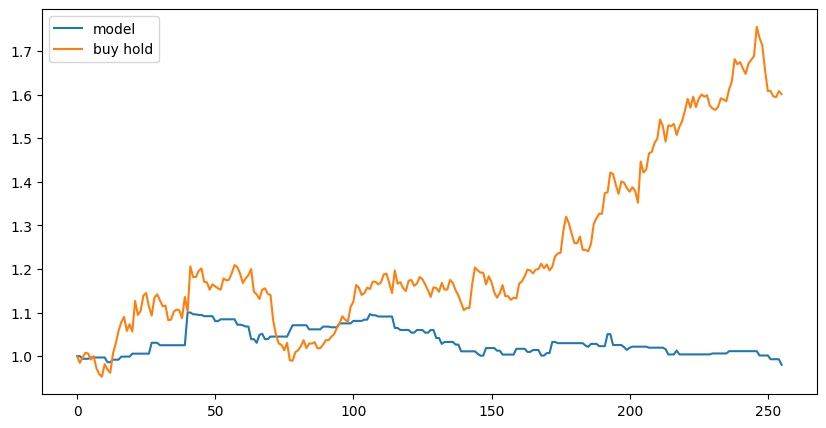

In [6]:
trials = 1
plt.figure(figsize = (10, 5))
for i in range(trials):
    torch.cuda.empty_cache()
    y_pred, df_b = backtest_plot(i)
plt.savefig(f'Model_Result/{Model}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')
torch.cuda.empty_cache()
    

In [7]:
df_b.Close.iloc[-1]/df_b.Close.iloc[0]

1.6008600061099687

In [8]:
stock_symbol.split('.')[0]

'2454'